In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
import imageio

In [2]:

import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'


PyTorch version: 2.0.1
Torchvision version: 0.15.2
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/kw/3t8qd9fd6hlfbqdps6pvpchw0000gn/T/pip-req-build-zt_ebdh7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/kw/3t8qd9fd6hlfbqdps6pvpchw0000gn/T/pip-req-build-zt_ebdh7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


## SET-UP


Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [21]:
# Some constants 
INPUT_FOLDER_DTI =  "/Applications/tez/tez_data/ADNI/027_S_4801/AX_DTI/2012-10-02_15_15_00.0/I337934/" # Our input 
patients_dcm = os.listdir(INPUT_FOLDER_DTI)
patients_dcm.sort()
patients_dcm[:10]

['ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140306284_1747_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140306956_50_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140307066_90_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140307112_2424_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140307175_1727_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140307237_1627_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140307284_2365_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140307440_1745_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140307487_1984_S169486_I337934.dcm',
 'ADNI_027_S_4801_MR_AX_DTI_br_raw_20121003140307565_1850_S169486_I337934.dcm']

In [22]:
image_dir = INPUT_FOLDER_DTI + patients_dcm[0]
DTI_pictures_vol = imageio.volread(image_dir)
print(DTI_pictures_vol.shape)
type(DTI_pictures_vol)


Reading DICOM (examining files): 1/2576 files (0.0%)

143/2576 files (5.6%289/2576 files (11.2438/2576 files (17.0584/2576 files (22.7728/2576 files (28.3875/2576 files (34.01023/2576 files (39.7%1168/2576 files (45.3%1315/2576 files (51.0%1462/2576 files (56.8%1508/2576 files (58.5%1651/2576 files (64.1%1794/2576 files (69.6%1935/2576 files (75.1%2080/2576 files (80.7%2227/2576 files (86.5%2371/2576 files (92.0%2518/2576 files (97.7%2576/2576 files (100.0%)
  Found 46 correct series.
Reading DICOM (loading data): 56/56  (100.0%)
(56, 256, 256)


imageio.core.util.Array

In [23]:
image_dti = DTI_pictures_vol[37,:,:]
image_dti = np.array(image_dti)
type(image_dti)
maxx = np.max(image_dti)
image_dti = (image_dti / maxx)

image_dti_RGB = np.tile(image_dti[:,:,np.newaxis], 3)
image_dti_RGB.shape

(256, 256, 3)

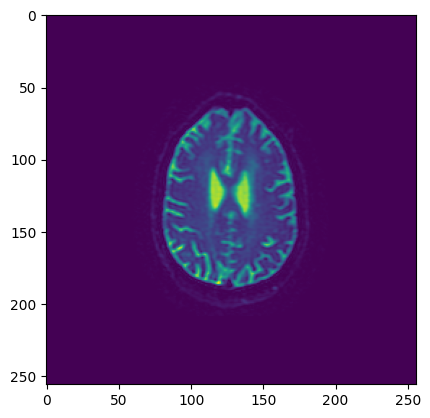

In [24]:
plt.imshow(image_dti_RGB[:,:,1])

In [25]:
image = (image_dti_RGB * 255).round().astype(np.uint8)

In [26]:
image2 = (image_dti_RGB * 255).round().astype(np.uint8)

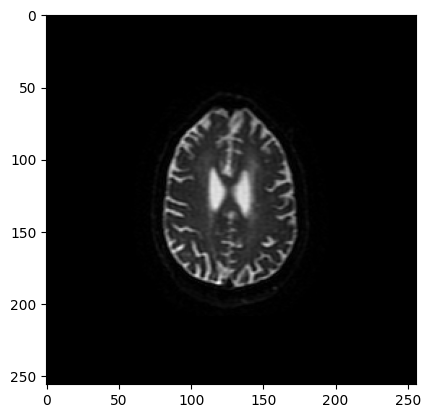

In [27]:
plt.imshow(image2)

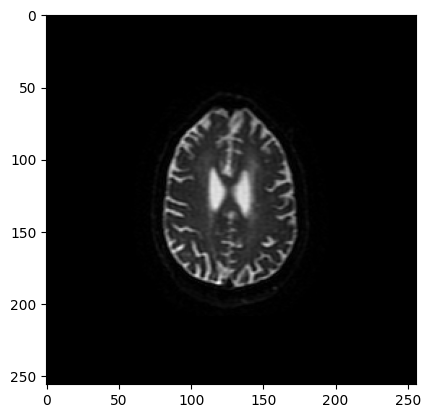

In [28]:
plt.imshow(image)

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [29]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [30]:
predictor.set_image(image)

In [35]:
input_point = np.array([[125, 125]])
input_label = np.array([1])



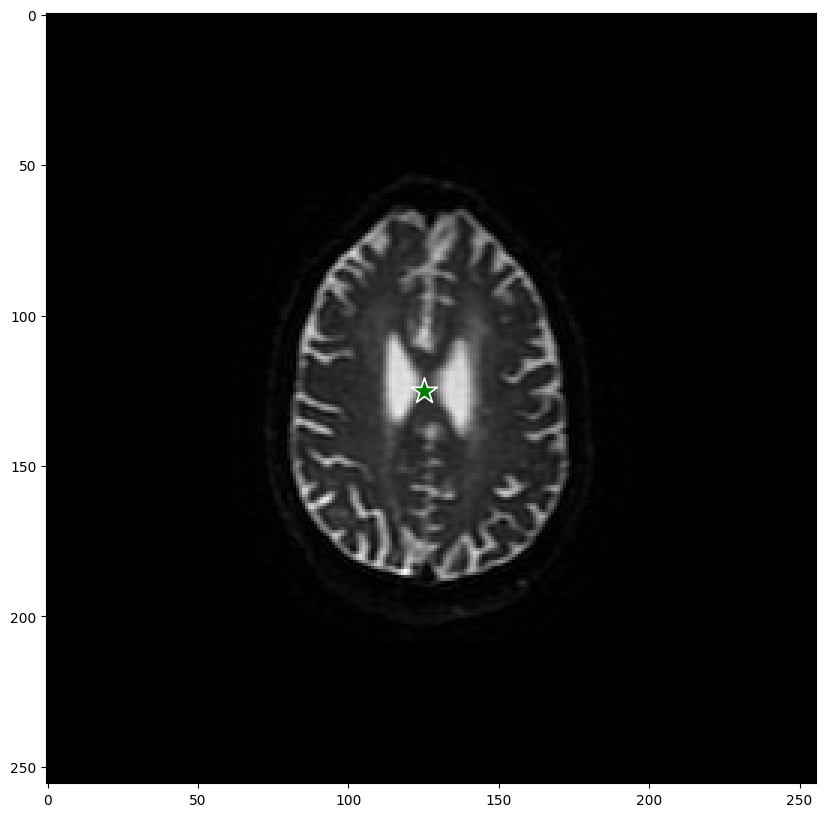

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [37]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [38]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [39]:
logits.shape

(3, 256, 256)

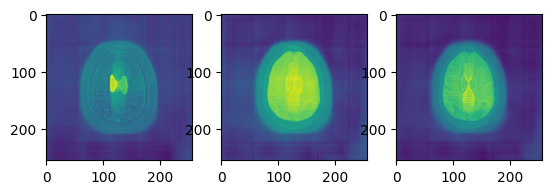

In [40]:
plt.subplot(1,3,1)
plt.imshow(logits[0,:,:])

plt.subplot(1,3,2)
plt.imshow(logits[1,:,:])

plt.subplot(1,3,3)
plt.imshow(logits[2,:,:])


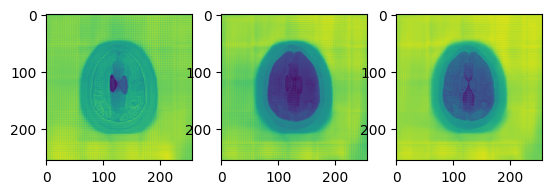

In [41]:
plt.subplot(1,3,1)
max_logits_0 = np.min(logits[0,:,:])
plt.imshow(logits[0,:,:]/max_logits_0)

plt.subplot(1,3,2)
max_logits_1 = np.min(logits[1,:,:])
plt.imshow(logits[1,:,:]/max_logits_1)

plt.subplot(1,3,3)
max_logits_2 = np.min(logits[2,:,:])
plt.imshow(logits[2,:,:]/max_logits_2)


In [42]:
scores

array([0.7418164, 0.986537 , 0.8947762], dtype=float32)

In [43]:
masks.shape  # (number_of_masks) x H x W

(3, 256, 256)

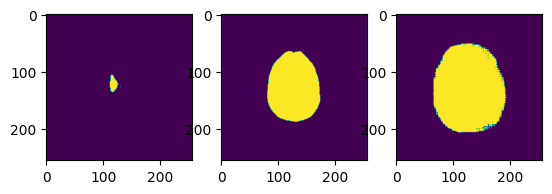

In [44]:

plt.subplot(1,3,1)
plt.imshow(masks[0,:,:]) # True or False values are  determined

plt.subplot(1,3,2)
plt.imshow(masks[1,:,:])

plt.subplot(1,3,3)
plt.imshow(masks[2,:,:])


In [ ]:
masked_image = np.ones(image.shape)
masked_image.shape

(256, 256, 3)

In [ ]:
masked_image = np.ones(image.shape)
masked_image.shape

masked_image[:,:,0] = image[:,:,0] * masks[1,:,:]
masked_image[:,:,1] = image[:,:,1] * masks[1,:,:]
masked_image[:,:,2] = image[:,:,2] * masks[1,:,:]

masked_image.shape

(256, 256, 3)

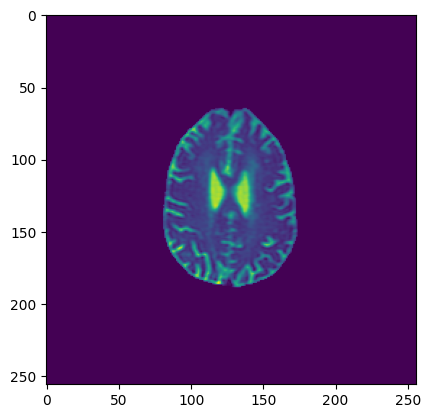

In [ ]:
plt.imshow(masked_image[:,:,0]) # uint8.  Burda veri kaybı yaşanabiliyor çünkü image masklama işlemi başlatırken float64 den uint8 bite düşürdük

In [ ]:
masked_images_dti_RGB = np.ones(image_dti_RGB.shape)
masked_images_dti_RGB[:,:,0] = image_dti_RGB[:,:,0] * masks[1,:,:]
masked_images_dti_RGB[:,:,1] = image_dti_RGB[:,:,1] * masks[1,:,:]
masked_images_dti_RGB[:,:,2] = image_dti_RGB[:,:,2] * masks[1,:,:]
masked_images_dti_RGB.shape

(256, 256, 3)

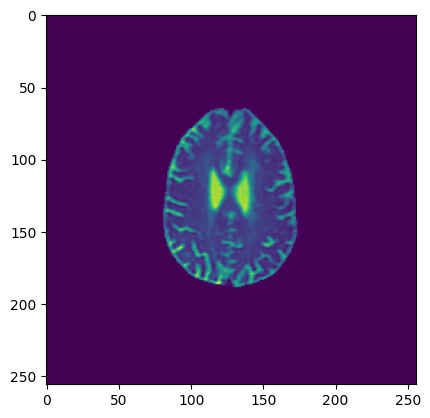

In [ ]:
plt.imshow(masked_images_dti_RGB[:,:,0]) # float64. ilk resmi maskledik ve veri kaybı yaşamadık

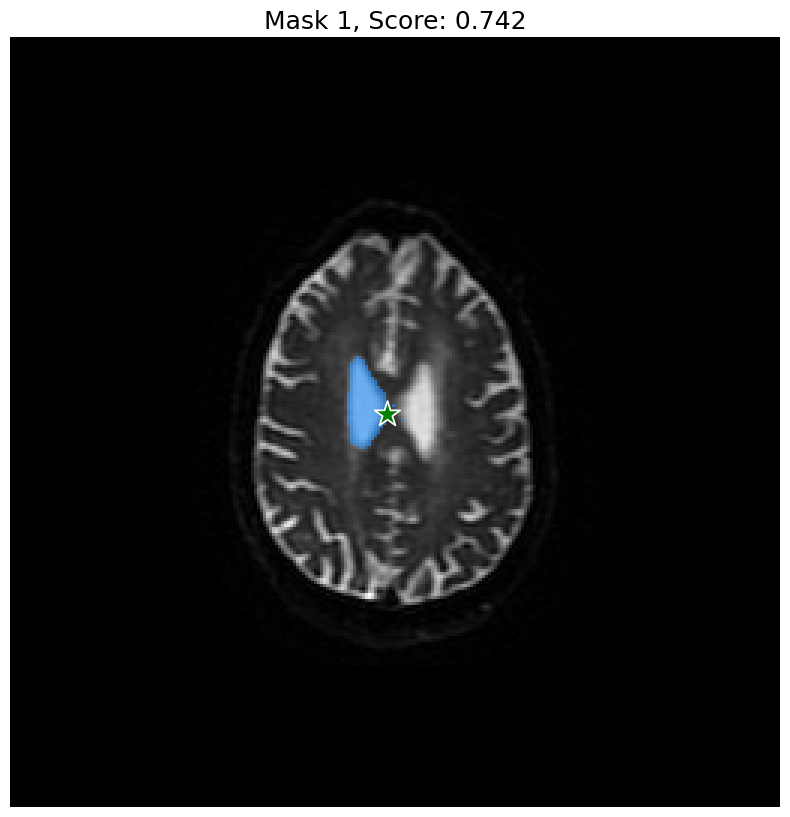

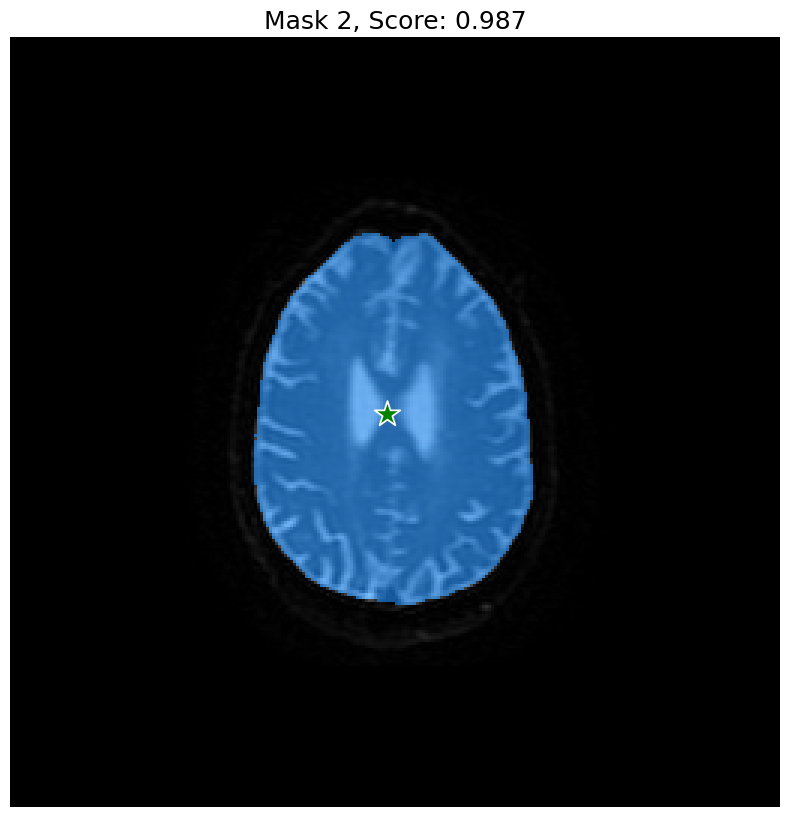

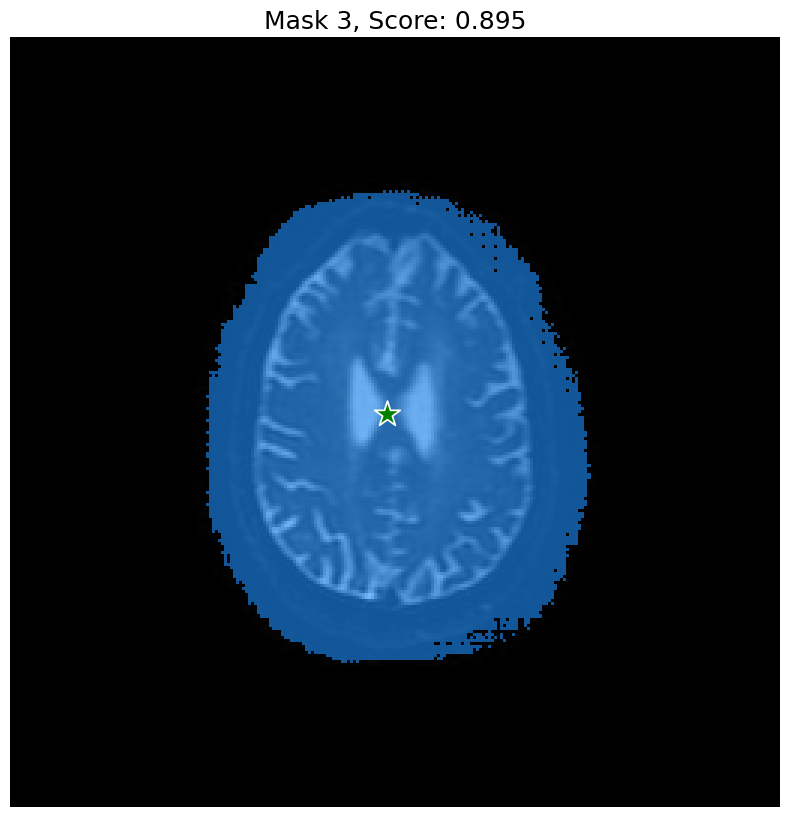

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [377]:
#### LOWB Picturess  ####

LOWB_pictures_files = "/Applications/tez/tez_data/TOMRUK_ZAHIDE_DTI/DTI/DIFFUSION_HIGHRES_LOWB_0012/"

LOWB_paths = os.listdir(LOWB_pictures_files)

LOWB_paths.sort()

len(LOWB_paths)

64

In [378]:
image_dir_lowb = LOWB_pictures_files + LOWB_paths[0]
DTI_pictures_vol_lowb = imageio.volread(image_dir_lowb)
print(DTI_pictures_vol_lowb.shape)
type(DTI_pictures_vol_lowb)

Reading DICOM (examining files): 1/64 files (1.6%64/64 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 64/64  (100.0%)
(64, 128, 128)


imageio.core.util.Array

In [458]:
image_dti_lowb = DTI_pictures_vol_lowb[40,:,:]
image_dti_lowb = np.array(image_dti_lowb)
type(image_dti_lowb)
maxx = np.max(image_dti_lowb)
image_dti_lowb = (image_dti_lowb / maxx)  # Normalized

image_dti_lowb_RGB = np.tile(image_dti_lowb[:,:,np.newaxis], 3)
image_dti_lowb_RGB.shape

image_lowb = (image_dti_lowb_RGB * 255).round().astype(np.uint8)

In [457]:
image_dti_lowb_RGB[:,:,1] == image_dti_lowb

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

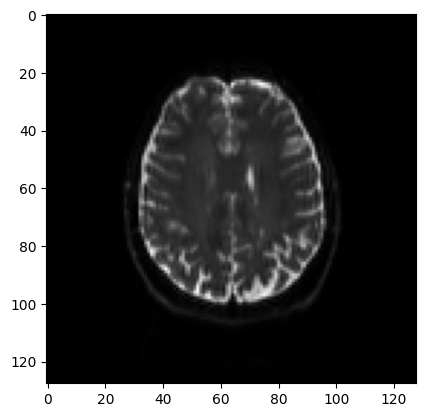

In [453]:
plt.imshow(image_dti_lowb_RGB)

In [431]:
image_dti_lowb.shape

(128, 128)

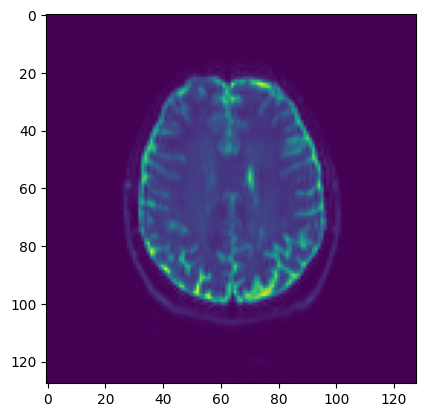

In [432]:
plt.imshow(image_dti_lowb)

In [382]:
predictor.set_image(image_lowb)

In [383]:
input_point = np.array([[64, 64]])
input_label = np.array([1])

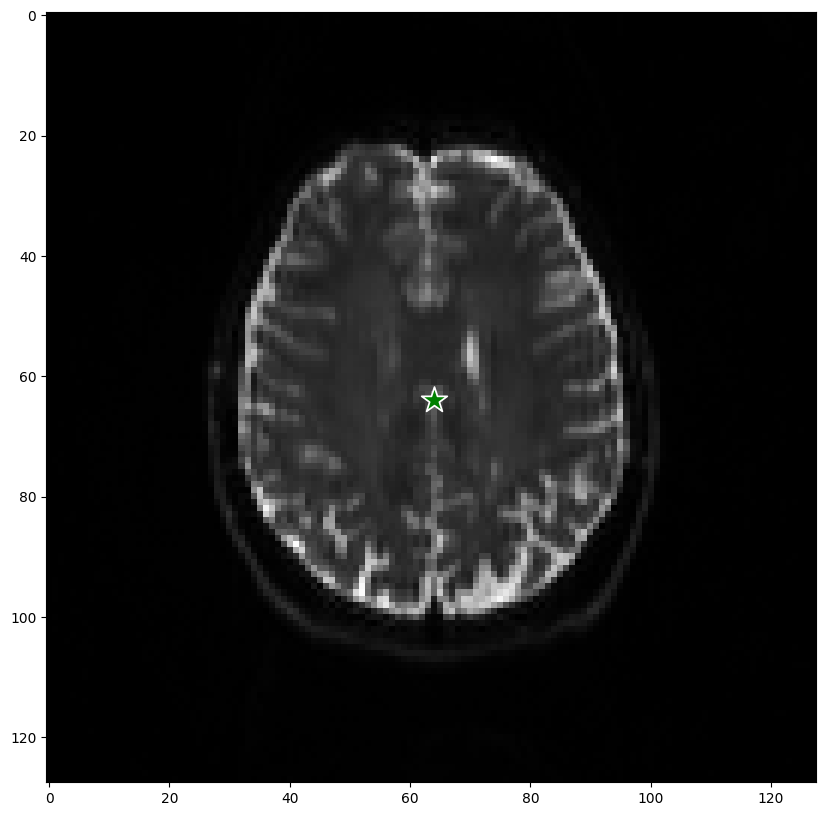

In [384]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [385]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [386]:
scores

array([0.5877595, 1.0003825, 0.993786 ], dtype=float32)

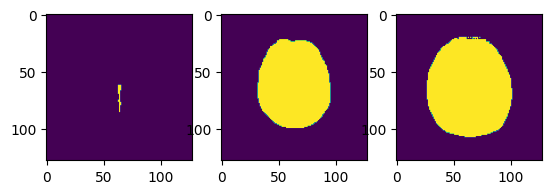

In [387]:

plt.subplot(1,3,1)
plt.imshow(masks[0,:,:]) # True or False values are  determined

plt.subplot(1,3,2)
plt.imshow(masks[1,:,:])

plt.subplot(1,3,3)
plt.imshow(masks[2,:,:])

In [388]:
masked_image_lowb = np.ones(image_lowb.shape)
masked_image_lowb.shape

masked_image_lowb[:,:,0] = image_lowb[:,:,0] * masks[1,:,:]
masked_image_lowb[:,:,1] = image_lowb[:,:,1] * masks[1,:,:]
masked_image_lowb[:,:,2] = image_lowb[:,:,2] * masks[1,:,:]

masked_image_lowb.shape

(128, 128, 3)

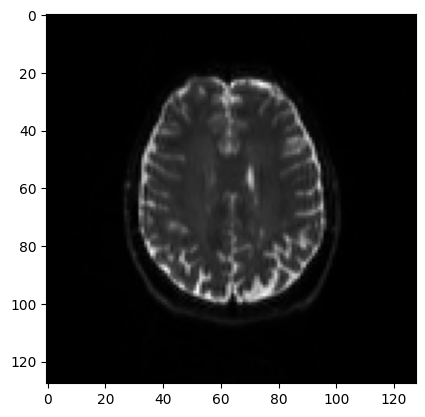

In [452]:
plt.imshow(image_lowb)

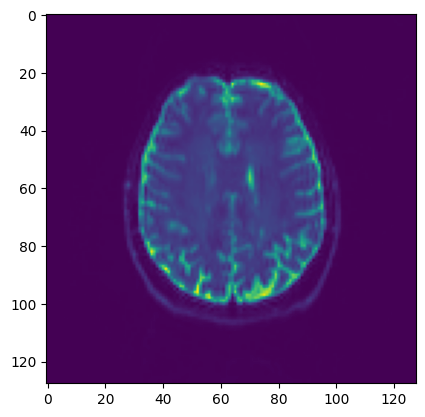

In [395]:
plt.imshow(image_lowb[:,:,0])

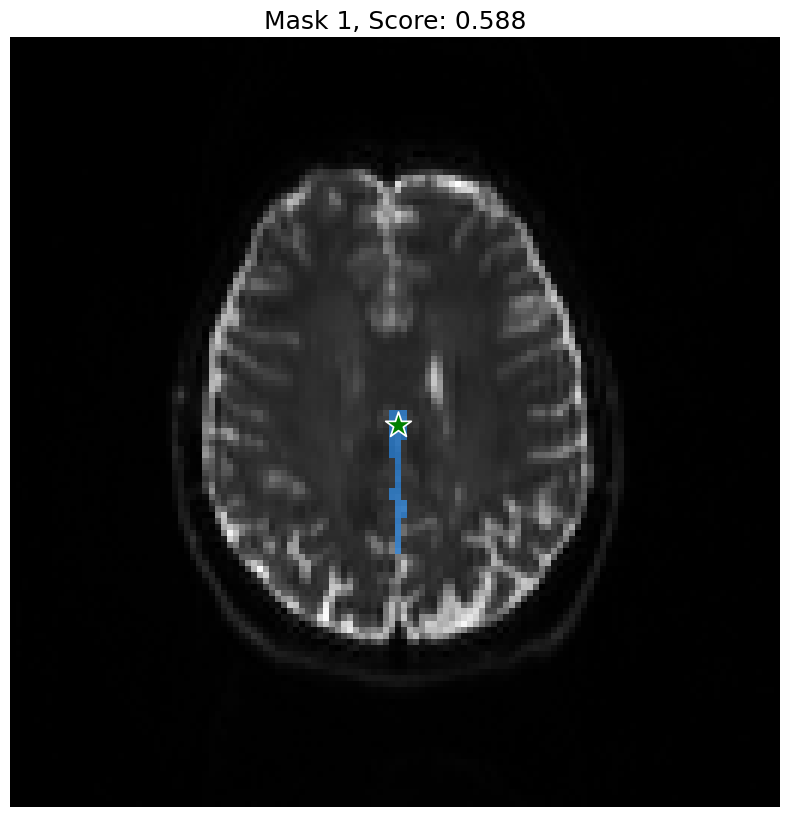

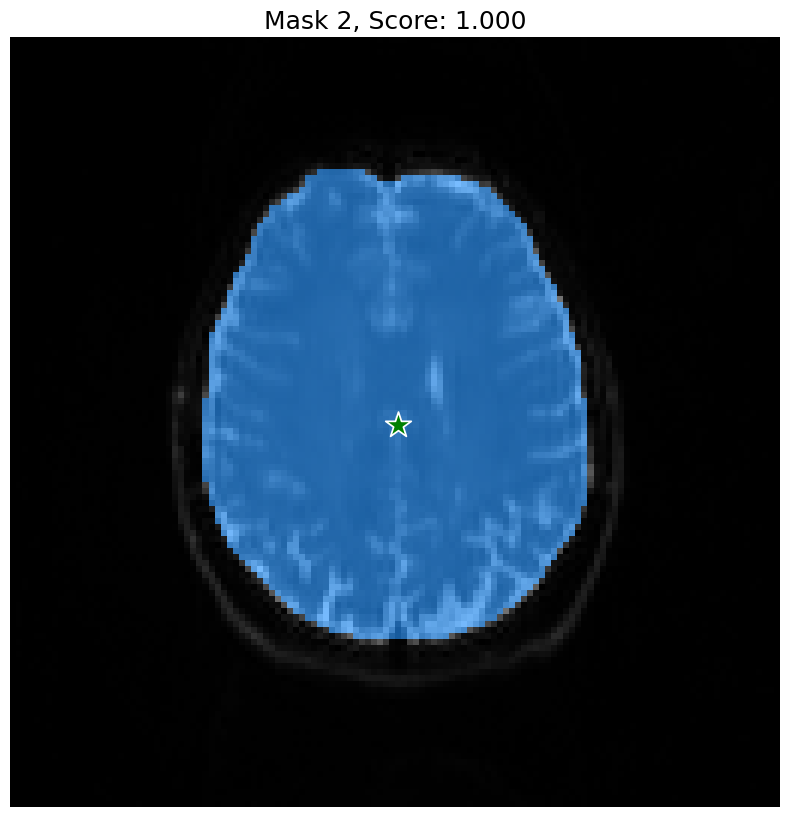

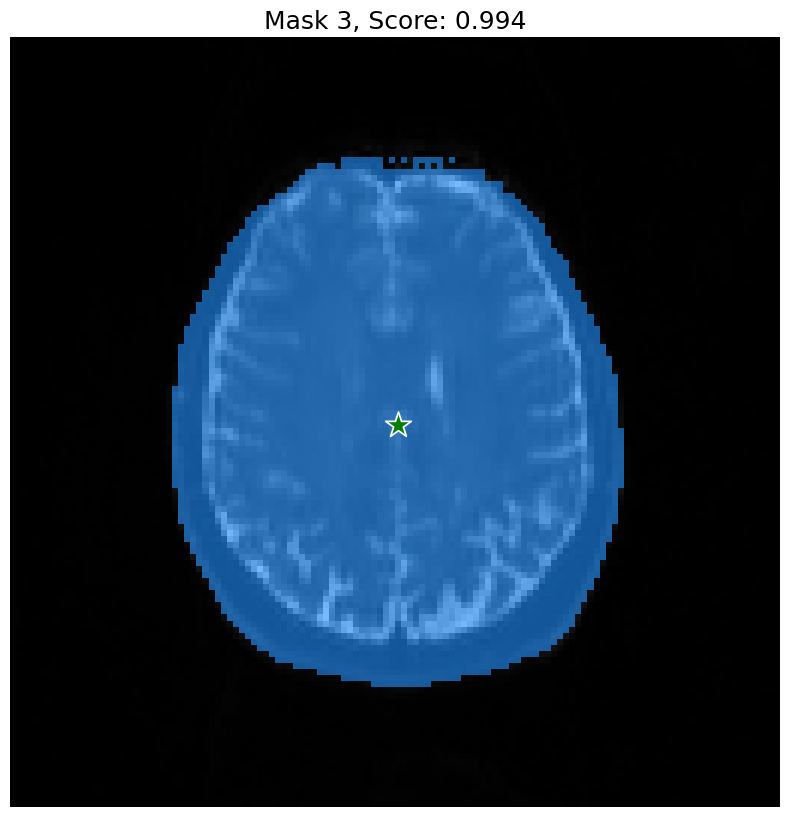

In [471]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image_lowb)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

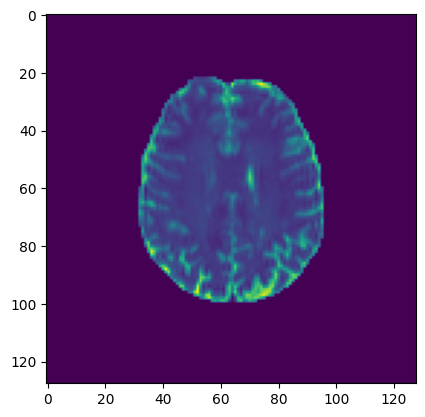

In [394]:
plt.imshow(masked_image_lowb[:,:,0]) # uint8.  Burda veri kaybı yaşanabiliyor çünkü image masklama işlemi başlatırken float64 den uint8 bite düşürdük

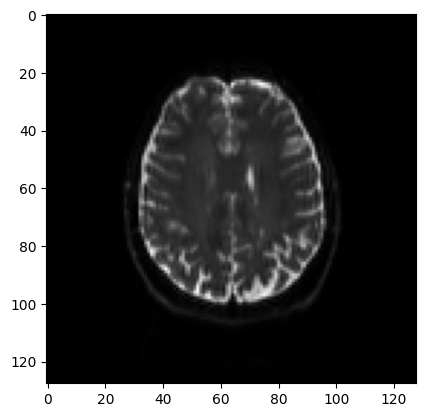

In [444]:
plt.imshow(image_dti_lowb_RGB)

In [ ]:
image_dti_lowb_RGB

In [445]:
masked_images_dti_lowb_RGB = np.ones(image_lowb.shape)
masked_images_dti_lowb_RGB[:,:,0] = image_dti_lowb_RGB[:,:,0] * masks[1,:,:]
masked_images_dti_lowb_RGB[:,:,1] = image_dti_lowb_RGB[:,:,1] * masks[1,:,:]
masked_images_dti_lowb_RGB[:,:,2] = image_dti_lowb_RGB[:,:,2] * masks[1,:,:]
masked_images_dti_lowb_RGB.shape

(128, 128, 3)

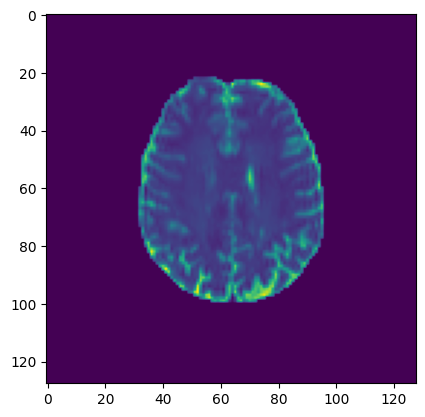

In [447]:
plt.imshow(masked_images_dti_lowb_RGB[:,:,1])

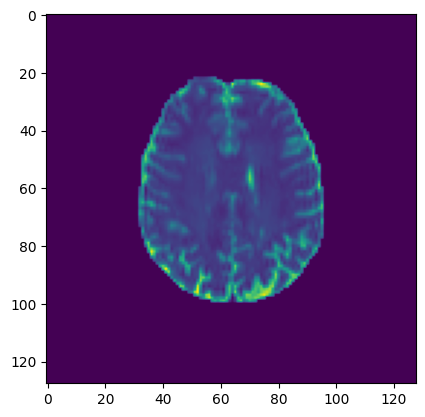

In [448]:
plt.imshow(masked_images_dti_lowb_RGB[:,:,0]) # float64. ilk resmi maskledik ve veri kaybı yaşamadık

In [450]:
masked_images_dti_lowb_RGB.shape

(128, 128, 3)

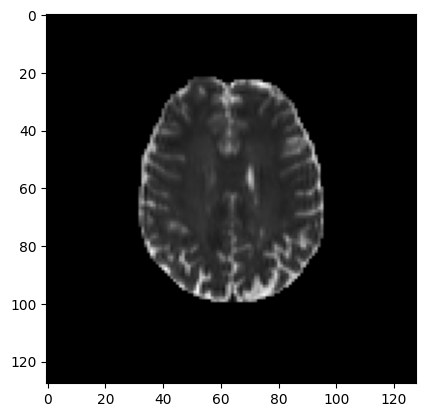

In [451]:
plt.imshow(masked_images_dti_lowb_RGB)

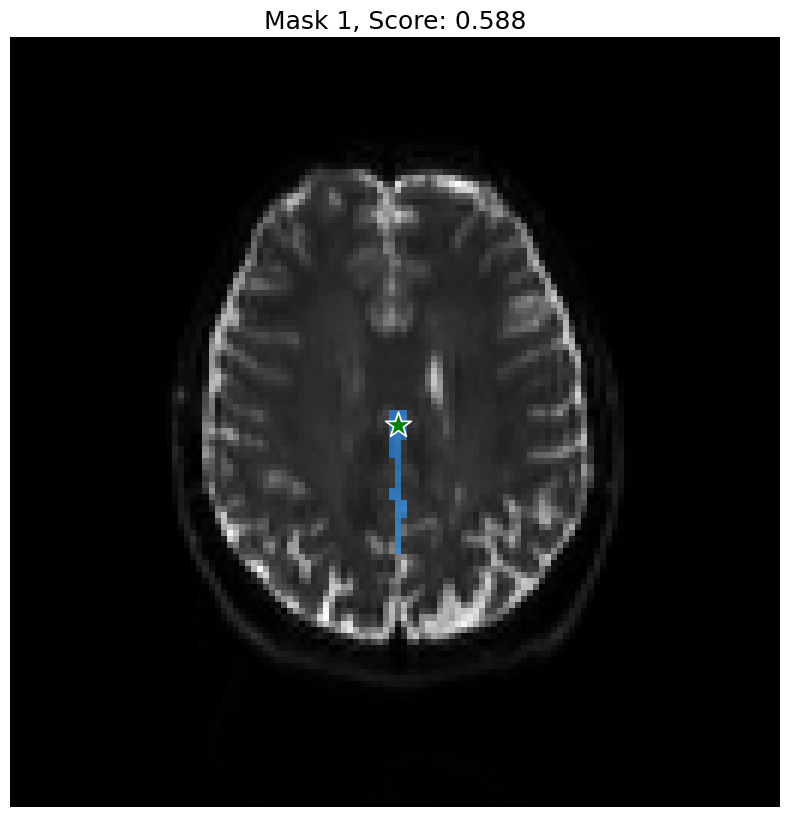

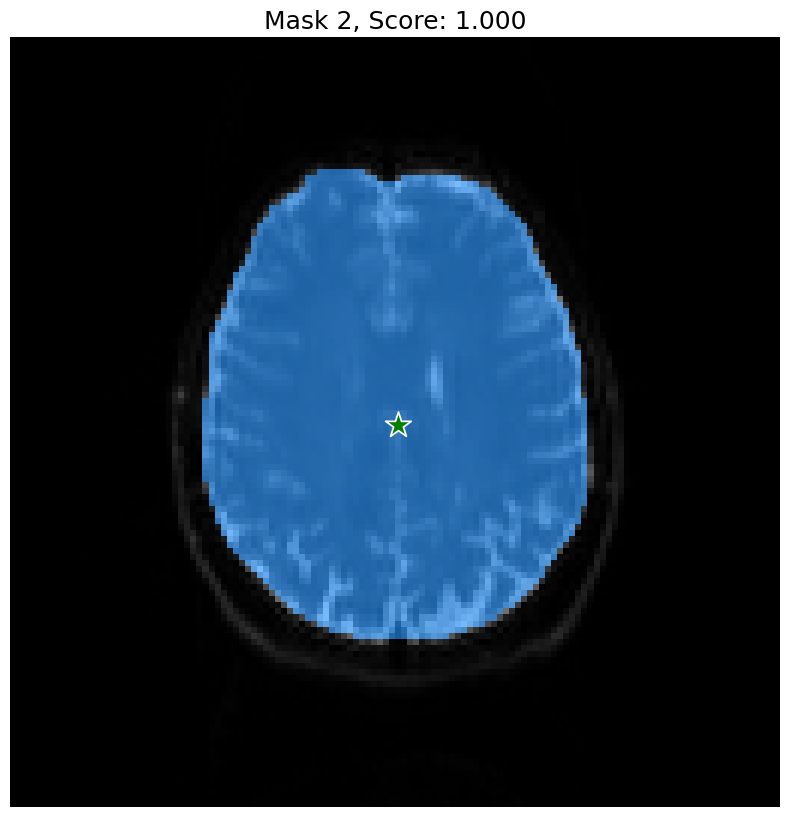

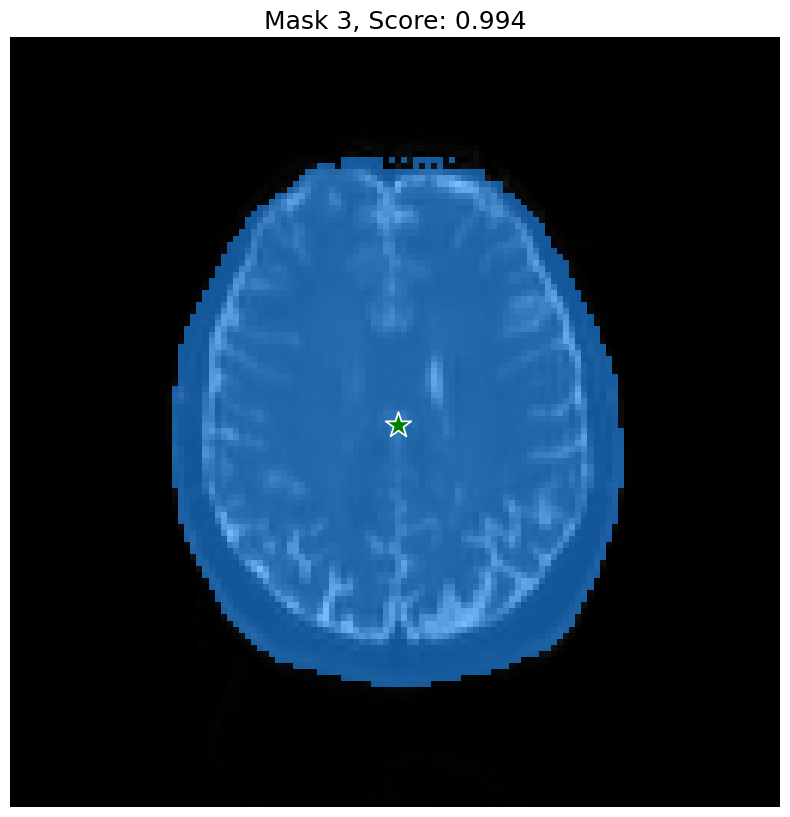

In [473]:
## Bu güzel oldu

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image_dti_lowb_RGB)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [504]:
raw_images = DTI_pictures_vol_lowb[40,:,:]
raw_images.shape

(128, 128)

In [463]:
masked_raw_lowb_RGB = np.ones(image_lowb.shape)
masked_raw_lowb_RGB[:,:,0] = raw_images * masks[1,:,:]
masked_raw_lowb_RGB[:,:,1] = raw_images * masks[1,:,:]
masked_raw_lowb_RGB[:,:,2] = raw_images * masks[1,:,:]
masked_raw_lowb_RGB.shape

(128, 128, 3)

In [497]:
img = imageio.imread('/Applications/tez/kodlarım/python_code/Health.png')
type(img)


/var/folders/kw/3t8qd9fd6hlfbqdps6pvpchw0000gn/T/ipykernel_42298/3257650382.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/Applications/tez/kodlarım/python_code/Health.png')


numpy.ndarray

In [495]:
type(raw_images)

imageio.core.util.Array

In [514]:
masks.shape

(3, 128, 128)

In [519]:
raw_images.shape

(128, 128)

In [520]:
masks.shape

(3, 128, 128)

In [516]:
masked_k = raw_images * masks[1,:,:]

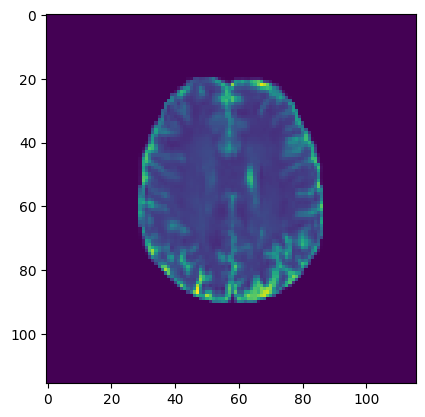

In [517]:
k = cv2.resize(masked_k,(116,116))
plt.imshow(k)

(116, 116)

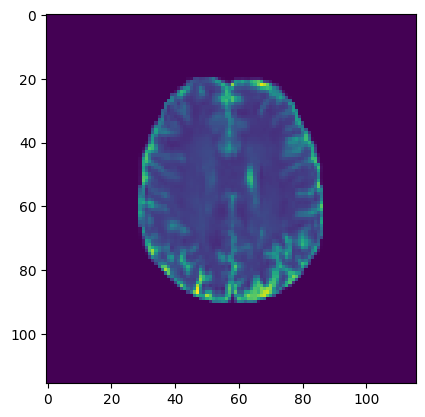

In [518]:
k_3d = (k * 255).round().astype(np.uint8)
plt.imshow(k)
k.shape

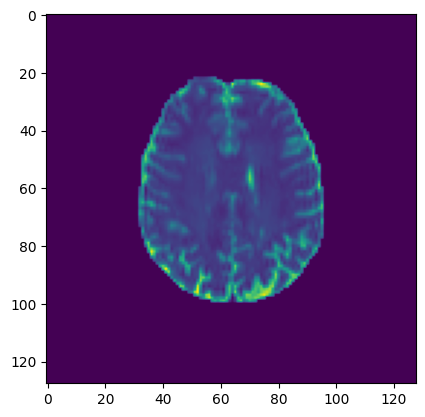

In [465]:
plt.imshow(masked_raw_lowb_RGB[:,:,0])

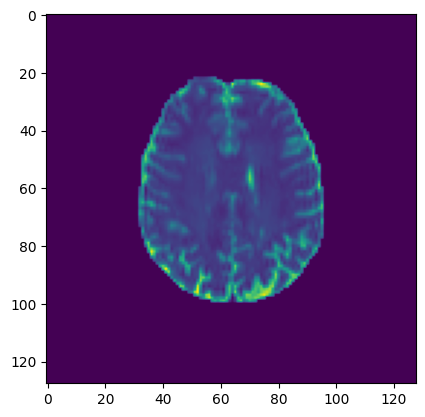

In [466]:
plt.imshow(masked_raw_lowb_RGB[:,:,1])

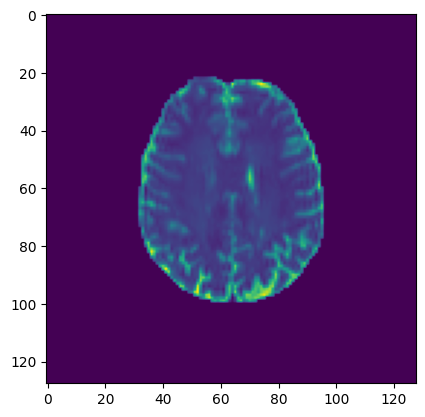

In [467]:
plt.imshow(masked_raw_lowb_RGB[:,:,2])

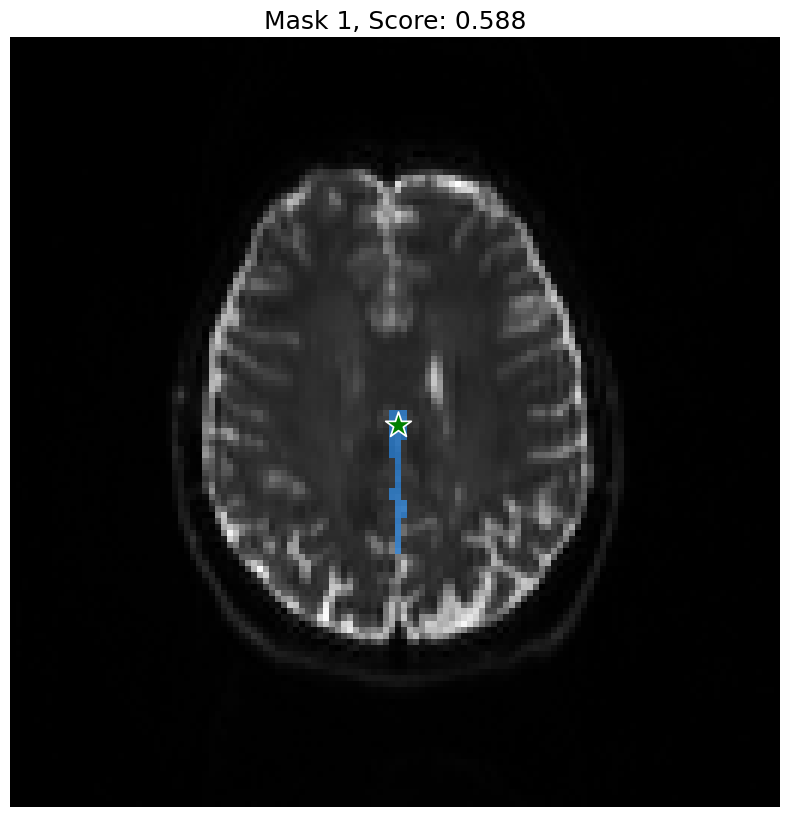

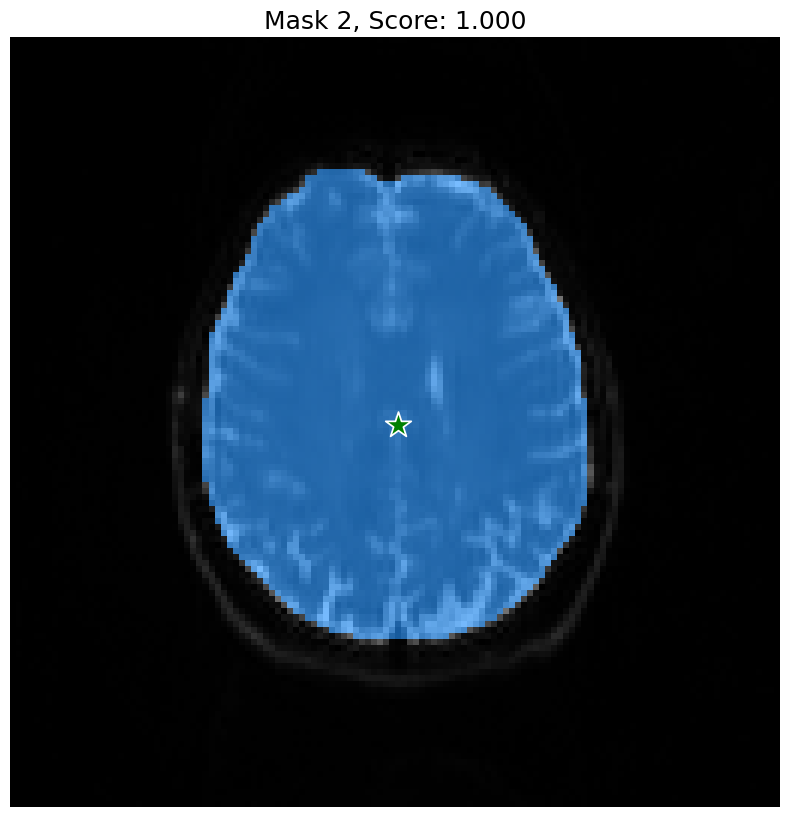

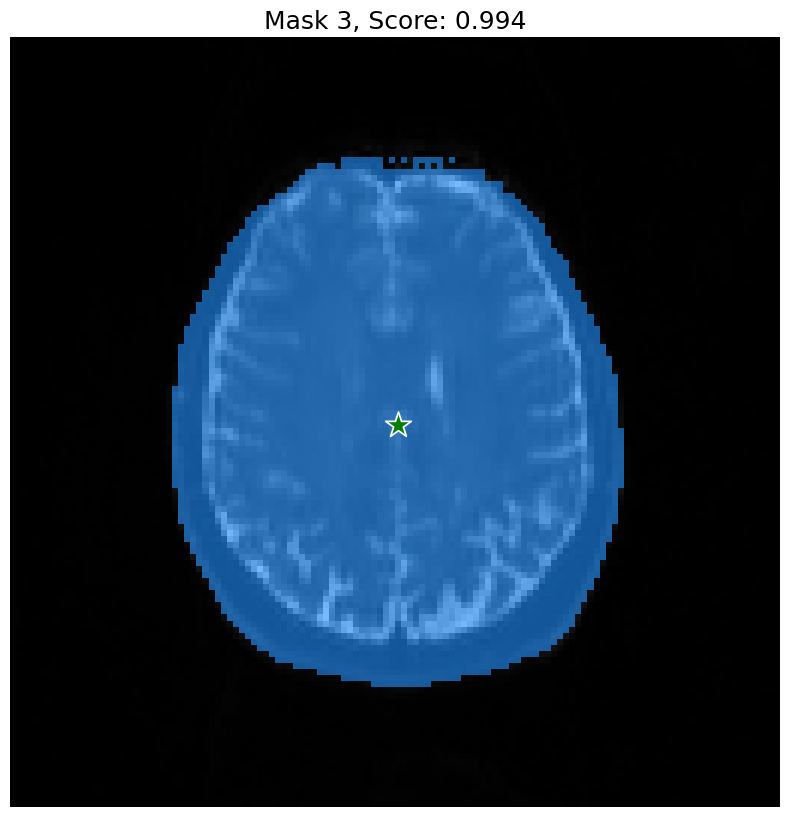

In [469]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image_lowb)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [475]:
raw_images = DTI_pictures_vol_lowb[40,:,:]

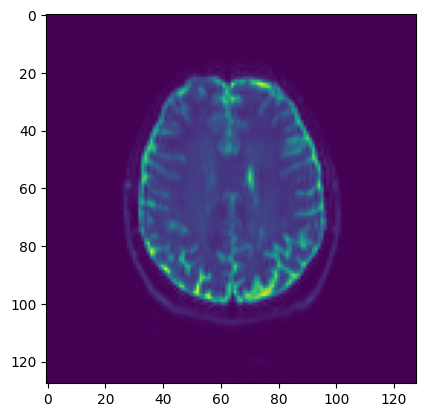

In [478]:
plt.imshow(raw_images)

In [476]:
amsked_images = raw_images * masks[1,:,:]

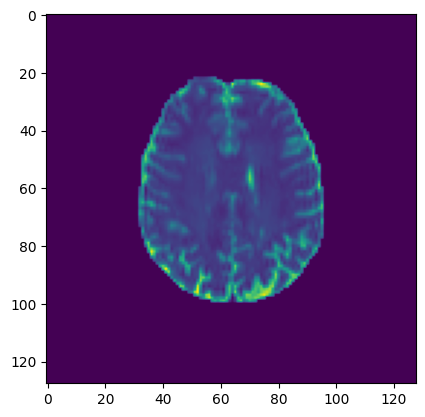

In [477]:
plt.imshow(amsked_images)